# <center>Predictive modelling with timeseries<center>
# <center>Baselines, stationarity and decomposition <center>

![Image](images/timeseries.jpg)

In [1]:
import pandas as pd
import numpy as np
from utils import adf_test
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot as plt

# jupyter lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

In [2]:
import statsmodels as sta
sta.__version__

'0.11.1'

# 1. Baselines 

The simplest forecasts one can do using univariate datasets are:
* 1. Average
* 2. Naive
* 3. Seasonal Naive
* 4. Moving Average
    * a. normal
    * b. cumulative
    
![Image](images/baselines.png) 

*Source: Hyndman and Athanasopoulos. www.otexts.com/fpp2/*


### Load the datasets

In [3]:
# example of trend data - wine sales
wine = pd.read_csv('datasets/wine_trend.csv')

# example of seasonal data - daily temperature
temperature = pd.read_csv('datasets/temperature_seasonal.csv')
temperature.set_index('date', drop=True, inplace=True)

# load a nice example for decomposition - production of electrical equipments
ele_df = pd.read_csv('datasets/elecequip.csv')

## Plot the data

In [6]:
wine.head()

,date,wine_sales
0,2020-01-01,266.0
1,2020-01-02,145.9
2,2020-01-03,183.1
3,2020-01-04,119.3
4,2020-01-05,180.3


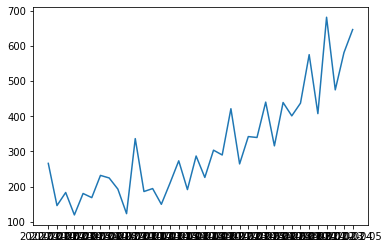

In [7]:
plt.plot(wine.date, wine.wine_sales)

In [14]:
temperature.head()

,temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


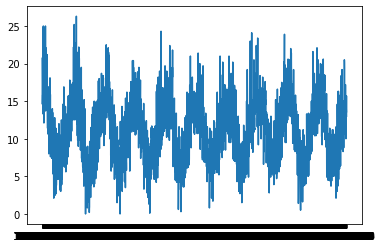

In [17]:
plt.plot(temperature.index, temperature.temp)

In [19]:
ele_df.head()

,time,value
0,1996.000000,79.35
1,1996.083333,75.78
2,1996.166667,86.32
3,1996.250000,72.60
4,1996.333333,74.86


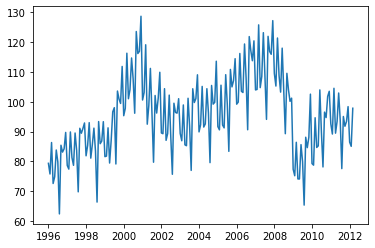

In [20]:
plt.plot(ele_df.time, ele_df.value)

## Naive methods and averages

Which baseline worked best in the case of trend data? Which one was best for seasonal data?

## Moving Average smoothing
### Understand the difference between `rolling` windows and `expanding` windows

Let's calculate a **moving average** and a **cumulative moving average** using the methods from pandas

In [22]:
ele_df['ma_5'] = ele_df.loc[:,'value'].rolling(window=2).mean()
ele_df['ma_10'] = ele_df.loc[:,'value'].rolling(window=20).mean()
ele_df['ma_exp'] = ele_df.loc[:,'value'].expanding().mean()

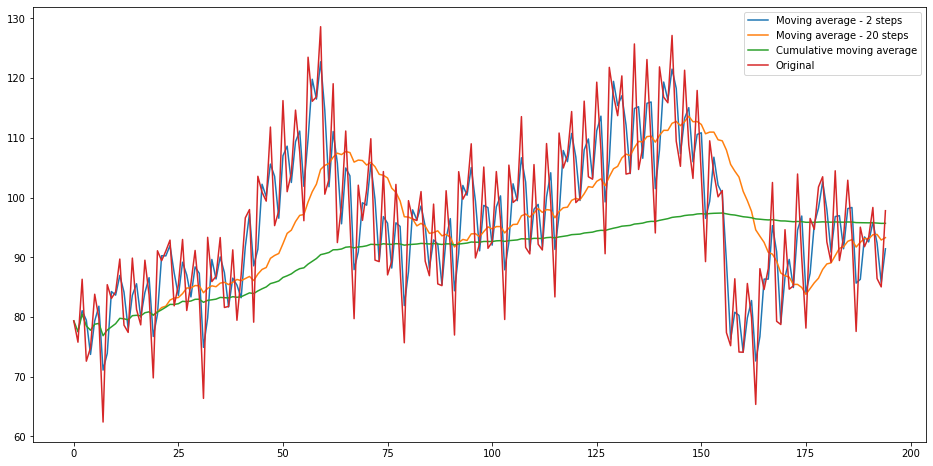

In [23]:
p = plt.figure(figsize=(16,8))
p = plt.plot(ele_df['ma_5'], label='Moving average - 2 steps')
p = plt.plot(ele_df['ma_10'], label='Moving average - 20 steps')
p = plt.plot(ele_df['ma_exp'], label='Cumulative moving average')
p = plt.plot(ele_df['value'], label='Original')
p = plt.legend(loc='best')
plt.show()

---

# 2. Time series Decomposition

### What is the data made of?  🤔

Time series can be better analysed if we know how each of its components behave.  
Typically, a time series  has 3 components:  
* `S` as the seasonal component  
* `T` as the trend component
* `R` as a residual component

If we consider that these components *add to each other*, the decomposition is said *additive*. 
Thus, in **additive decomposition** we have:  
> y(t) = S(t) + T(t) + R(t)  

And in **multiplicative decomposition** we have: 
> y(t) = S(t) * T(t) * R(t)  

**Example:** Decomposition of the Equipments dataset 

<AxesSubplot:>

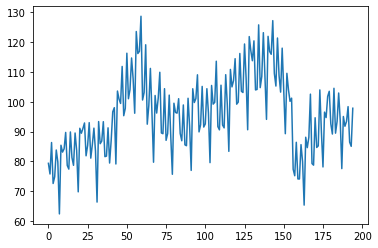

In [24]:
ele_df['value'].plot()

### **Run the additive decomposition**  

The function `seasonal_decompose()` from `statsmodels` is very helpful:  

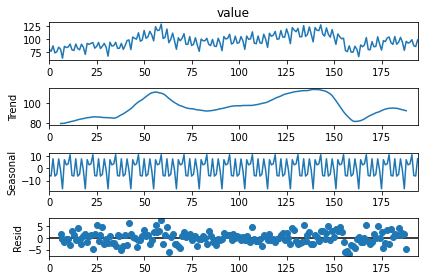

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ele_df['value'], model='additive', period=12).plot()

### Check the actual numbers coming from the decomposition:

In [26]:
result = seasonal_decompose(ele_df['value'], model='additive', period=12)
decomposed_series = pd.concat([result.observed, result.seasonal, result.trend, result.resid], axis=1)
decomposed_series.head(20)

,value,seasonal,trend,resid
0,79.35,-5.887662,NaN,NaN
1,75.78,-6.199273,NaN,NaN
2,86.32,8.083171,NaN,NaN
3,72.60,-6.314968,NaN,NaN
4,74.86,-4.818468,NaN,NaN
5,83.81,7.976088,NaN,NaN
6,79.80,-1.575338,79.750417,1.624921
7,62.41,-16.870416,79.789167,-0.508751
8,85.41,7.304324,80.005000,-1.899324
9,83.11,3.007671,80.513750,-0.411421


# 3. Stationarity

### Is the data stationary?  🤔

Stationarity means your time series does not have any `trend` or `seasonality`. Stationary time series will have no predictable patterns in the long-term. They will be very important in ARIMA, for example.
A commom method to investigate this is with the  **Augmented Dickey-Fuller Test**.

**Example:** Check if the wine data is stationary. If it is not, 
try with differencing and see what happens.

In [ ]:
# check if data is stationary
adf_test(wine.wine_sales)

# 4. Differencing 
### (will be super important in ARIMA)

The results of the ADF-test above show that the wine time series is non-stationary.  
Some methods will require that the data is stationary. We can still try to adjust it by using **differencing**.
>**Differencing** is the difference between consecutive observations. It reduces (or eliminates) trend and seasonality.

This procedure can be done quickly with the method `diff()` from library `statsmodels.tsa`.

Check the behavior of `diff()`

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
test = [20, 20, 20]
diff(test)

test = [20, 40, 60]
diff(test)

test = [40, 45, 34, 32, 41, 34, 41]
diff(test)
np.mean(diff(test))

test = [40, 45, 34, 32, 41, 34, 41]
diff(test, k_diff=2)
np.mean(diff(test, k_diff=2))

In [ ]:
wine['sales_diff'] = diff(wine['wine_sales'], k_diff=1)
wine['sales_diff'].plot()
adf_test(wine['sales_diff'])

---

# 5. Autocorrelation

Let's check the daily sales of one of Rossman's stores (Store 1):

In [ ]:
sales = pd.read_csv('datasets/rossman_train.csv')
stores = pd.read_csv('datasets/rossman_store.csv')

# join store features into the sales df
sales = pd.merge(sales, stores, on='Store', how='left')

In [ ]:
fig = px.scatter(sales[sales.Store==1], x="Date", y="Sales", color='DayOfWeek', width=800, height=500 )
fig = fig.add_trace(go.Line(x=sales.loc[sales.Store==1, 'Date'], y=sales[sales.Store==1].Sales, mode='lines'))
fig.show()

### Look in more detail to 2 or 3 weeks: Do you see any repeating patterns?

* The stores are closed sundays
* Sales every mondays tend to be higher than the other business days

**Overall** we see a cycle of 7 days in the sales -> **seasonality**   
How does that translate into autocorrelation?

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

title = 'Autocorrelation - Daily Sales'
# set the number of time steps to consider in the calculation
lags = 30 
plot_acf(sales[sales.Store==1].Sales, title=title, lags=lags);

## Interpretation of the ACF plot

* Autocorrelation with itself is always 1 
* The shaded area indicates the 95% confidence intervals for the **null hypothesis** that the autocorrelation with that specific time lag is, in fact, zero.
* Thus, in the example above, the autocorelation with time lag of 7, 14, 21 and so on, is in the order of ~62%. If we reject the null hypothesis, there's very small probability (<= 5%) of making a **Type I error**
* We can affirm that the daily sales of the Rossman store 1 has (strong) seasonal component, with a cycle of 7 days


### Autocorrelation plots (ACF) and stationarity

The ACF plots can be used as a diagnostic tool, they help to understand if the data is stationary.  
>For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.  
(Hyndman and Athanasopoulos 2018)


The plots below show the autocorrelation existing in the `wine` dataset, where we can see a significant positive autocorrelation
with lags 1 to 3 (first plot). Then, after applying a one-order differencing to the data, 

In [ ]:
title = 'Autocorrelation - wine sales before diff'
lags = 30
p = plot_acf(wine['wine_sales'],title=title,lags=lags);

In [ ]:
title = 'Autocorrelation - after diff'
lags = 30
p = plot_acf(wine.loc[1:, 'sales_diff'], title=title,lags=lags)

---

<a href='https://www.freepik.com/vectors/business'>Business vector created by freepik - www.freepik.com</a>